In [1]:
import os
import torch
import pandas as pd
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from random import random, randrange
from torchvision import transforms,models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import clip

In [2]:
PRODUCTS_CSV_PATH = os.path.join("data","product_list.csv")
CLEAN_IMAGES_CSV_PATH = os.path.join("data","DAM")
TEST_IMAGES_PATH = os.path.join("data","test_image_headmind")

In [3]:
products_df = pd.read_csv(PRODUCTS_CSV_PATH)
products_df.head()

,MMC,Product_BusinessUnitDesc
0,010M03A1116X9000,W RTW
1,010M09A1101X0863,W RTW
2,010M27A0006X0200,W RTW
3,011A11A1166X4150,W RTW
4,011A11A1166X9000,W RTW


In [4]:
products_df.columns = ["MMC","ProdBU"]
products_df.head()

,MMC,ProdBU
0,010M03A1116X9000,W RTW
1,010M09A1101X0863,W RTW
2,010M27A0006X0200,W RTW
3,011A11A1166X4150,W RTW
4,011A11A1166X9000,W RTW


In [5]:
products_df["ProdBU"].unique()

array(['W RTW', 'W SLG', 'W Bags', 'W Shoes', 'Watches', 'W Accessories'],
      dtype=object)

In [6]:
products = {
    "MMC": products_df["MMC"].to_list(),
    "ProdBU": products_df["ProdBU"].to_list()
}
products

{'MMC': ['010M03A1116X9000',
  '010M09A1101X0863',
  '010M27A0006X0200',
  '011A11A1166X4150',
  '011A11A1166X9000',
  '011B13A6014X0200',
  '011B48A3874X0863',
  '011D01A1166X5645',
  '011D01A1166X9000',
  '011D02A1166X3250',
  '011G05ACMIXX0863',
  '011G07A1166X9000',
  '011G12A1166X4150',
  '011G13A1212X0200',
  '011J12A1166X9000',
  '011J22X8801X9000',
  '011J50A8976X9632',
  '011P11A1166X9000',
  '011P12A3862X0863',
  '011P34A1166X5435',
  '011R33A7970X9639',
  '011R68A1212X4150',
  '011R70A1166X9000',
  '011V41A3062X5435',
  '012A09A3232X5597',
  '012B03A3985X5902',
  '012J03A3236X0835',
  '013L02A4006X5435',
  '013T03WC437X9663',
  '013T05TU430X0854',
  '014C10AM034X1705',
  '014E01CM514X0863',
  '014E20CM514X0863',
  '014E20TU507X0850',
  '014P02AM042X5800',
  '014S26AM028X2847',
  '014S52AM044X9650',
  '014S52WC029X0863',
  '014S55AM042X0820',
  '014S58AM304X0200',
  '014S59AM005X4220',
  '014S62TM033X5902',
  '014S73AM105X4235',
  '014S92AM032X0863',
  '015R30AL030X9000',
  '

In [7]:
training_images = {}

for mmc in products["MMC"]:
    training_images[mmc] = os.path.join(CLEAN_IMAGES_CSV_PATH,f'{mmc}.jpeg')

In [8]:
class TestImgDataset(Dataset):
    def __init__(self,img_list,transform=None):
        self.img_list = img_list
        self.transform = transform
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        img_path = self.img_list[idx]
        img = Image.open(img_path)
        return self.transform(img)


class ImageDataset(Dataset):
    def __init__(self, img_dict,transform=None):
        self.img_dict = img_dict
        self.transform = transform
        self.key_list = list(img_dict.keys())
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        self.transform2 = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=mean, std=std)
        ])

    def __len__(self):
        return len(self.img_dict.keys())
    
    def __getitem__(self,idx):
        img_path = self.img_dict[self.key_list[idx]]
        image1 = Image.open(img_path)
        image1 = self.transform(image1)
        mask = (image1 == 0).all(dim=0)
        image1[:,mask] = 1.
        same_idx = torch.tensor(1.)

        if randrange(2):
            idx2 = randrange(len(self.key_list))
            img_path = self.img_dict[self.key_list[idx2]]
            if idx != idx2:
                same_idx = torch.tensor(-1.)

        image2 = Image.open(img_path)
        image2 = self.transform2(image2)
        
        return (image1, image2), same_idx

In [9]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transformation = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=mean,std=std),
    transforms.RandomPerspective(),
    transforms.RandomAffine(90,(0.1,0.1),(0.7,1.1))
])

test_transformation = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=mean, std=std)
])
imgs = os.listdir(TEST_IMAGES_PATH)
img_list = [os.path.join(TEST_IMAGES_PATH,i) for i in imgs]
img_dataset = ImageDataset(training_images, transform=transformation)
compar_dataset = ImageDataset(training_images,transform=test_transformation)
client_dataset = TestImgDataset(img_list,transform=test_transformation)
train_dataloader = DataLoader(img_dataset,batch_size=8,shuffle=True)
test_dataloader = DataLoader(compar_dataset, batch_size=1, shuffle=False)
client_dataloader = DataLoader(client_dataset,batch_size=1, shuffle=False)

tensor(-1.)


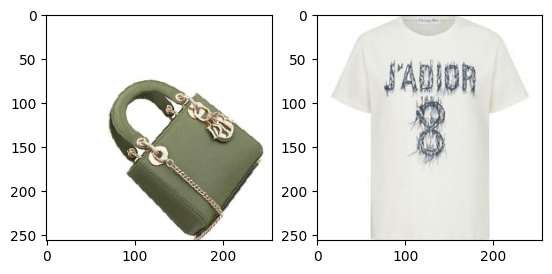

In [10]:
(img1, img2), same_idx = next(iter(train_dataloader))
fix, axs = plt.subplots(ncols=2, squeeze=False)
axs[0,0].imshow(img1[0].permute(1,2,0))
axs[0,1].imshow(img2[0].permute(1,2,0))
print(same_idx[0])

In [11]:
model, preprocess = clip.load("ViT-B/32",device="cpu")

100%|███████████████████████████████████████| 338M/338M [00:19<00:00, 18.3MiB/s]


In [157]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CosineEmbeddingLoss()
for epoch in range(5):
    print(f"EPOCH {epoch}")
    for i, data in enumerate(train_dataloader):
        (img1, img2), same_img = data
        img1, img2, same_img = img1.to(device), img2.to(device), same_img.to(device)
        optimizer.zero_grad()
        output1, output2 = model(img1), model(img2)
        loss = criterion(output1,output2,same_img)
        if i%20 == 0:
            print(f"{i} loss train: {loss.item()}")

        loss.backward()
        optimizer.step()

EPOCH 0
0 loss train: 0.5103464126586914
20 loss train: 0.6080130338668823
40 loss train: 0.6197848916053772
60 loss train: 0.3786300718784332
80 loss train: 0.30577534437179565
100 loss train: 0.23189282417297363
120 loss train: 0.21057556569576263
140 loss train: 0.3745611906051636
160 loss train: 0.21889325976371765
180 loss train: 0.45721155405044556
200 loss train: 0.28849655389785767
220 loss train: 0.46472665667533875
240 loss train: 0.1305670142173767
260 loss train: 0.10270784795284271
280 loss train: 0.09772920608520508
300 loss train: 0.2619237005710602
320 loss train: 0.3467596769332886
340 loss train: 0.2976028025150299
EPOCH 1
0 loss train: 0.2197384536266327
20 loss train: 0.22955840826034546
40 loss train: 0.11414587497711182
60 loss train: 0.15906941890716553
80 loss train: 0.12119336426258087
100 loss train: 0.15827257931232452
120 loss train: 0.13048821687698364
140 loss train: 0.19405385851860046
160 loss train: 0.15868882834911346
180 loss train: 0.1665522903203964

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [158]:
torch.save(model.state_dict(), "weights50.pt")

In [12]:
model.load_state_dict(torch.load("weights.pt",weights_only=True))

<All keys matched successfully>

In [ ]:
model.eval()

embedding_list = []
for i,data in enumerate(test_dataloader):
    (image1,_),_ = data
    image1 = image1.to(device)
    output = model(image1.half())
    embedding_list.append(output)
embedding_list

In [15]:
model.eval()

client_embedding_list = []
for data in tqdm(client_dataloader):
    image1 = data
    image1 = image1.to(device)
    client_embedding_list.append(model(image1.half()))

client_embedding_list

  1%|▏         | 1/80 [00:40<53:03, 40.29s/it]


KeyboardInterrupt: 

In [35]:
client_embedding_tensor = torch.stack(client_features).squeeze(1)
embedding_tensor = torch.stack(reference_features).squeeze(1)

client_embedding_tensor_normalized = client_embedding_tensor / client_embedding_tensor.norm(dim=1, keepdim=True)
embedding_tensor_normalized = embedding_tensor / embedding_tensor.norm(dim=1, keepdim=True)

cosine_similarities = torch.mm(client_embedding_tensor_normalized, embedding_tensor_normalized.t())

closest_indices = torch.argsort(cosine_similarities, dim=1,descending=True)[:,:5]
closest_indices

tensor([[1439, 1194, 1537, 1496, 1585],
        [1318, 1585, 1157, 1317, 1295],
        [1585, 1507,  654, 1758, 1060],
        [1702, 1685, 1665, 1691,  654],
        [ 900, 1665, 1685, 1669, 1667],
        [2076, 2010, 2019, 2084, 2094],
        [1286,  760, 1689, 1658, 1585],
        [1157, 1076,  688,  852, 1081],
        [ 852,  868, 1005, 1157,  870],
        [1356, 1250, 1249, 1348,  849],
        [2347, 2348, 2537, 2449, 2630],
        [ 224, 1886, 1699,  993,  968],
        [2217, 2215, 2205, 1939, 2216],
        [1938, 2203, 2205, 2217, 2204],
        [1139, 1499, 1157,  747, 1192],
        [1076, 1693, 1701, 1689, 1708],
        [1804, 2030, 1822, 1996, 1886],
        [2000, 1999, 1819, 1996, 1821],
        [1853, 1981, 1987, 1872, 2040],
        [1770, 1850, 1875, 1860, 1881],
        [1850, 1875, 1861, 1847, 1881],
        [1850, 2004, 1861, 1875, 1877],
        [1850, 1860, 1846, 1875, 1829],
        [2037, 1804, 2030, 2039, 1850],
        [2347, 2348, 2537, 2528, 2741],


In [42]:
training_images[list(training_images.keys())[1439]]

'data\\DAM\\M500SJAAUXM334.jpeg'

In [164]:
img_list

['data\\test_image_headmind\\image-20210928-102713-12d2869d.jpg',
 'data\\test_image_headmind\\image-20210928-102718-2474636a.jpg',
 'data\\test_image_headmind\\image-20210928-102721-8eaea48f.jpg',
 'data\\test_image_headmind\\image-20210928-102725-7e28b44c.jpg',
 'data\\test_image_headmind\\image-20210928-102729-f53d9faf.jpg',
 'data\\test_image_headmind\\image-20210928-102732-8502aded.jpg',
 'data\\test_image_headmind\\image-20210928-102747-05631ad4.jpg',
 'data\\test_image_headmind\\image-20210928-102758-fd41d453.jpg',
 'data\\test_image_headmind\\image-20210928-102802-39d3c54f.jpg',
 'data\\test_image_headmind\\image-20210928-102806-79d7094b.jpg',
 'data\\test_image_headmind\\image-20210928-102940-20cd277d.jpg',
 'data\\test_image_headmind\\image-20210928-103146-c8d2fedb.jpg',
 'data\\test_image_headmind\\image-20210928-103157-a46cc321.jpg',
 'data\\test_image_headmind\\image-20210928-103200-ce51703f.jpg',
 'data\\test_image_headmind\\image-20210928-103217-38e9a47d.jpg',
 'data\\te

In [18]:
reference_features = []
for key in tqdm(training_images.keys()):
    image = preprocess(Image.open(training_images[key])).unsqueeze(0)
    with torch.no_grad():
        reference_features.append(model.encode_image(image).flatten())

100%|██████████| 2766/2766 [04:32<00:00, 10.16it/s]


In [17]:
client_features = []
for im in tqdm(img_list):
    image = preprocess(Image.open(im)).unsqueeze(0)
    with torch.no_grad():
        client_features.append(model.encode_image(image).flatten())

100%|██████████| 80/80 [00:17<00:00,  4.62it/s]
